In [88]:
import sys
import importlib

sys.path.append("../")

from src import utils
from src.utils import *

from src import plot_utils
from src import graph_utils
from src import inpaint_utils
from src import fiberatlas_utils

from sklearn.cluster import AgglomerativeClustering

In [97]:
plt.style.use('dark_background')
cmap = mpl.colormaps.get_cmap('jet')
cmap.set_extremes(under='black', over='black')

## Goal

The goal of this notebook is to do inpainting. Allowing for negative weightings of bundle to generate bundles, and allowing as well negatively connected bundles to exist

### Prerequisite loading

In [89]:
scale = 1
connFilename = f'../../atlas_data/fiber_atlas/probconnatlas/wm.connatlas.scale{scale}.h5'
hf = h5py.File(connFilename, 'r')

centers = np.array(hf.get('header').get('gmcoords'))
nsubject = hf.get('header').get('nsubjects')[()]
dim = hf.get('header').get('dim')[()]
fiber_affine = hf.get('header').get('affine')[()]

gmregions_names = hf.get('header').get('gmregions')[()]
nb_regions = gmregions_names.shape[0]

# NOTE; use the masks if necessary when 
# we select too much bundles for reconstruction
gm_mask_subj = nib.load('../../atlas_data/moviedata_fMRI_eg/gm_mask_subj7.nii').get_fdata() 
wm_mask_subj = (gm_mask_subj + 1) % 2


consistency_view = fiberatlas_utils.get_aggprop(hf, 'consistency')
length_view = fiberatlas_utils.get_aggprop(hf, 'length')
nbStlines_view = fiberatlas_utils.get_aggprop(hf, 'numbStlines')
nb_regions = consistency_view.shape[0]
thresh_subjapp = int(np.ceil(nsubject * 0.1)) 

fmri_coords = load(f'../resources/scale{scale}_fmri2atlas_coords_div{int(np.ceil(thresh_subjapp))}.pkl')
bundle_affine = np.array(hf.get('header').get('affine'))[()]

voxel_fmri = nib.load('../../atlas_data/moviedata_fMRI_eg/movie_group_fmri.nii')
vdim = voxel_fmri.shape[:3]
rest_affine = voxel_fmri.affine

In [90]:
### Compute the pcc seed connectivity
# Load the rest fmri in MNI space volumes

ftimecourse = nib.load('../../atlas_data/moviedata_fMRI_eg/movie_group_fmri.nii').get_fdata()
rest_affine = nib.load('../../atlas_data/moviedata_fMRI_eg/movie_group_fmri.nii').affine

# Visualize the corresponding probabilstic voxels for this region
root = '../../atlas_data/fiber_atlas/yasser_datacomp/volspams_compress/'
atlas_of_interest = f'compresslausanne2018.scale{scale}.sym.corrected.ctx+subc.volspams.nii.gz'
prob_regions, prob_affine = (nib.load(root + atlas_of_interest).get_fdata(), nib.load(root + atlas_of_interest).affine)

# threshold the prob_regions into binary mask
thresh = 0.1  # empirically chosen thresh to have at least 3 subjects overlap on that region
mask_regions = (prob_regions > thresh).astype(float)

rmask_regions_nifti = nimg.resample_to_img(nib.Nifti1Image(mask_regions, affine=prob_affine), 
                                           nib.Nifti1Image(ftimecourse[:,:,:,0], affine=rest_affine), interpolation = 'nearest')
rmask_regions = rmask_regions_nifti.get_fdata()

In [91]:
thresh_subjapp = int(np.ceil(nsubject * 0.1))
bundle_affine = np.array(hf.get('header').get('affine'))[()]

voxel_fmri = nib.load('../../atlas_data/moviedata_fMRI_eg/movie_group_fmri.nii')
vdim = voxel_fmri.shape[:3]
fmri_coords = load(f'../resources/scale{scale}_fmri2atlas_coords_div{int(np.ceil(thresh_subjapp))}.pkl')

bundles_labels = []
for i in tqdm(range(1,nb_regions + 1)):
    for j in range(i,nb_regions + 1):
        tmp = fiberatlas_utils.get_bundles_betweenreg(hf, i, j, verbose=False)
        if tmp is None: continue
        if np.sum(tmp[:,3] >= (thresh_subjapp)) == 0: continue
        bundles_labels.append((i,j))

100%|██████████| 95/95 [00:20<00:00,  4.62it/s]


In [92]:
p1,p2 = 0,0
bundle_opt = load(f"../resources/weights_regressors_activity/weighted_bundle_activity_timevertex{thresh_subjapp}_scale{scale}_p1-{p1}_p2-{p2}.pkl")

In [93]:
inpainted_array = []
for k in tqdm(range(ftimecourse.shape[-1])):
    tmp_inpainted, tmp_inpainted2 = inpaint_utils.interpolate_activity(fmri_coords, bundles_labels, bundle_opt[k], vdim, 
                                                        wmmask=wm_mask_subj, normalizing=True, verbose=False, probaflag=True)
    inpainted_array.append(tmp_inpainted2)
inpainted_array = np.array(inpainted_array)

100%|██████████| 460/460 [05:26<00:00,  1.41it/s]


### Timewise clustering and average (CAPS like)

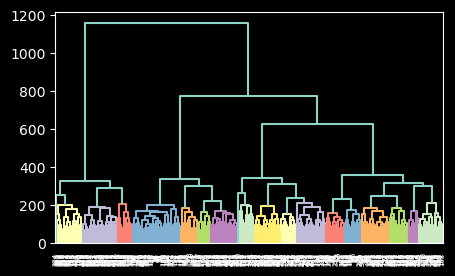

In [102]:
from scipy.cluster.hierarchy import dendrogram, linkage

ethresh = 220
fig, ax = plt.subplots(1, figsize=(5,3))
linkage_data = linkage(bundle_opt, method='ward', metric='euclidean')
linkage_data_cosine = linkage(bundle_opt, method='average', metric='cosine')
dendrogram(linkage_data, ax=ax, color_threshold=ethresh)
plt.show()

In [95]:
cluster_ward = AgglomerativeClustering(
    n_clusters=None, affinity='euclidean', linkage='ward', compute_full_tree=True, distance_threshold=ethresh)

cluster_ward.fit(bundle_opt)
labels_ward = cluster_ward.labels_

nb_clusterward = len(np.unique(labels_ward))

new_inpainted_array = deepcopy(inpainted_array)
new_inpainted_array[new_inpainted_array==-100000] = 0
patterns = [new_inpainted_array[labels_ward==k].mean(axis=0) for k in range(nb_clusterward)]

/Users/mikichan/miniconda3/envs/microstruct_atlasing/lib/python3.8/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


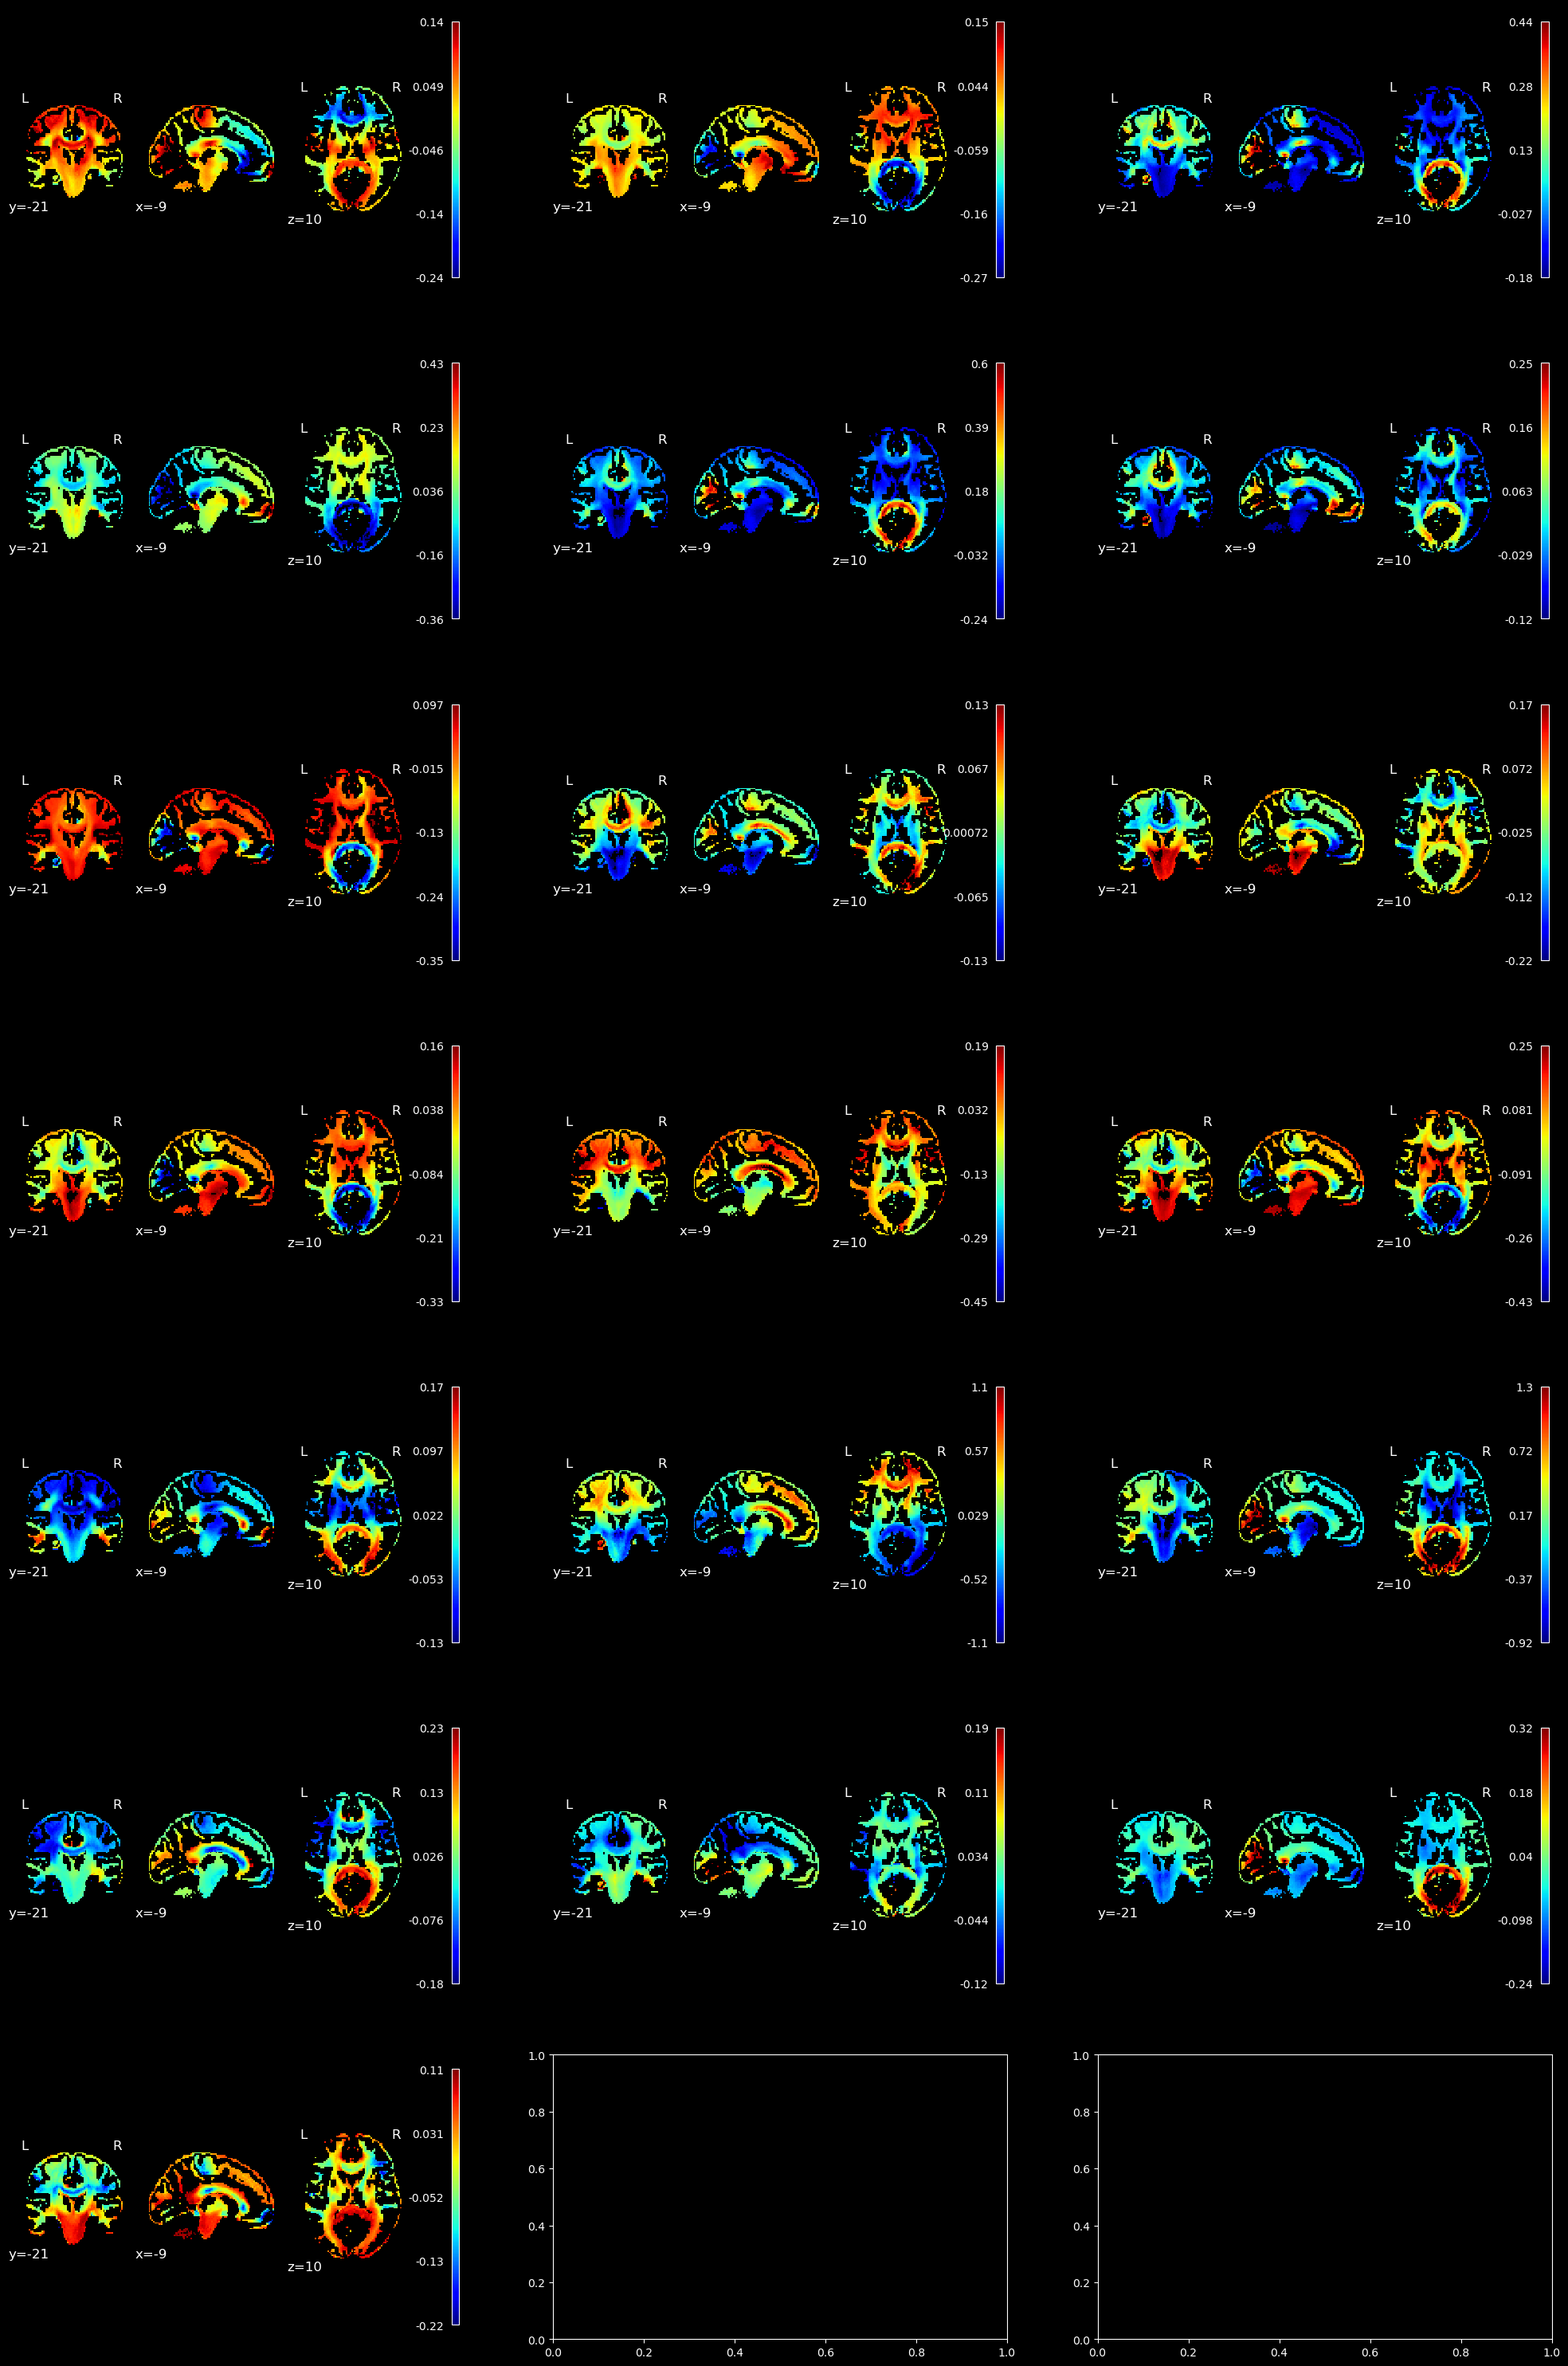

In [98]:
fig, ax = plt.subplots(nb_clusterward//3+1, 3, figsize=(25, nb_clusterward*2))
for k in range(nb_clusterward):

    inpaint_mod = deepcopy(patterns[k])
    inpaint_mod[inpaint_mod!=0] = inpaint_mod[inpaint_mod!=0] - inpaint_mod[inpaint_mod!=0].mean()
    vmin = np.quantile(inpaint_mod, 0.001)
    vmax = np.quantile(inpaint_mod, 0.999)
    inpaint_mod[inpaint_mod==0] = -10000
    plot_epi(nib.Nifti1Image(inpaint_mod, affine=rest_affine),
                         colorbar=True, cut_coords=(-9,-21,10), axes=ax[k//3,k%3],
                        cmap=cmap, vmin=vmin, vmax=vmax, draw_cross=False)

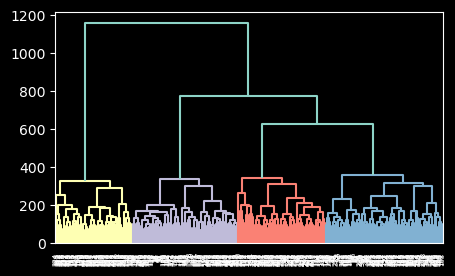

In [99]:
ethresh = 400
fig, ax = plt.subplots(1, figsize=(5,3))
linkage_data = linkage(bundle_opt, method='ward', metric='euclidean')
linkage_data_cosine = linkage(bundle_opt, method='average', metric='cosine')
dendrogram(linkage_data, ax=ax, color_threshold=ethresh)
plt.show()

In [100]:
cluster_ward = AgglomerativeClustering(
    n_clusters=None, affinity='euclidean', linkage='ward', compute_full_tree=True, distance_threshold=ethresh)

cluster_ward.fit(bundle_opt)
labels_ward = cluster_ward.labels_

nb_clusterward = len(np.unique(labels_ward))

new_inpainted_array = deepcopy(inpainted_array)
new_inpainted_array[new_inpainted_array==-100000] = 0
patterns = [new_inpainted_array[labels_ward==k].mean(axis=0) for k in range(nb_clusterward)]

/Users/mikichan/miniconda3/envs/microstruct_atlasing/lib/python3.8/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


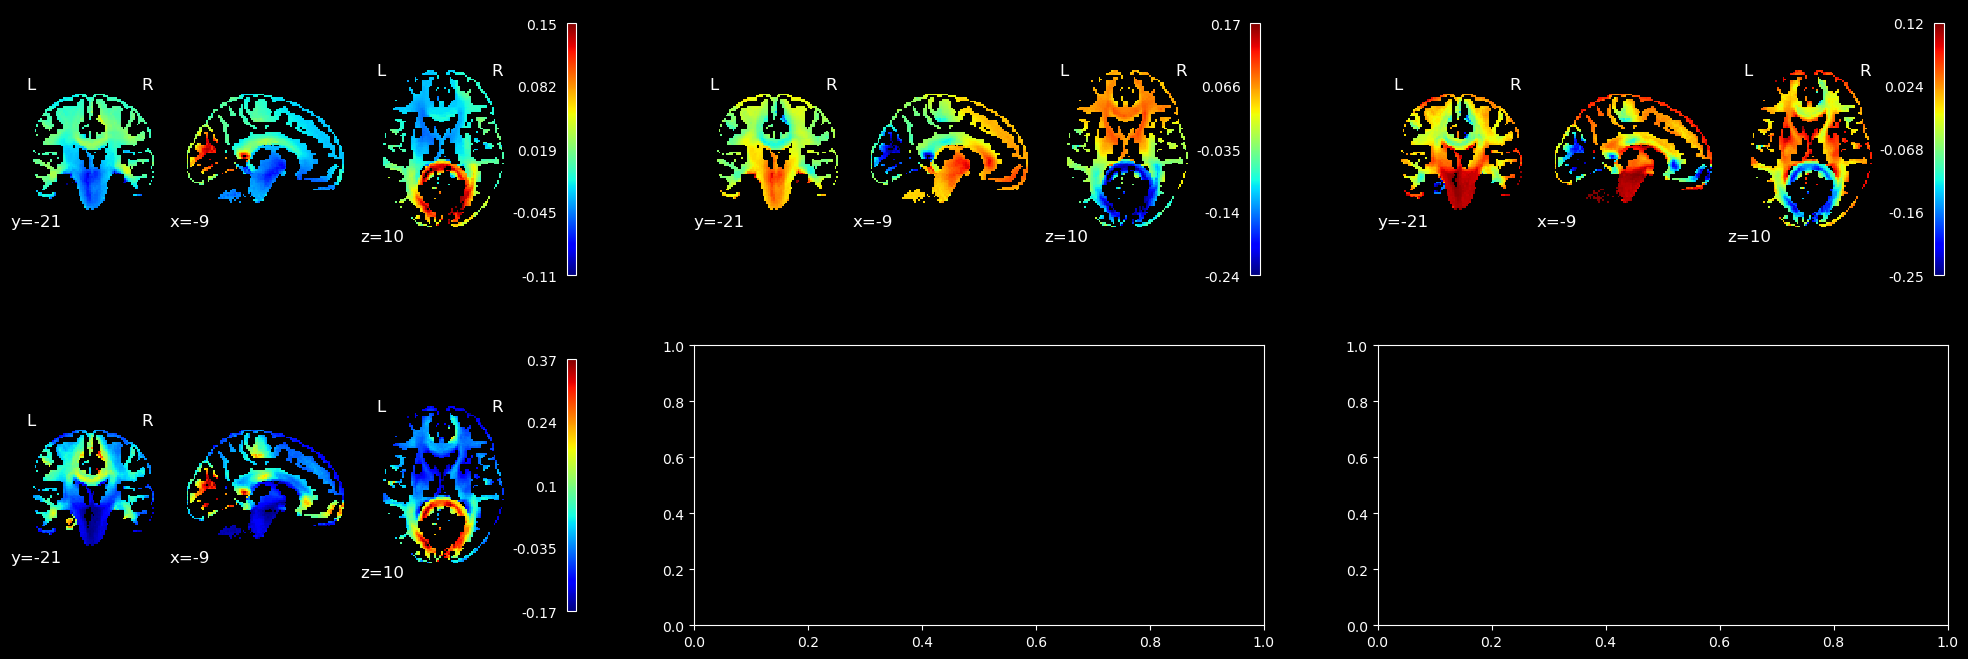

In [101]:
fig, ax = plt.subplots(nb_clusterward//3+1, 3, figsize=(25, nb_clusterward*2))
for k in range(nb_clusterward):

    inpaint_mod = deepcopy(patterns[k])
    inpaint_mod[inpaint_mod!=0] = inpaint_mod[inpaint_mod!=0] - inpaint_mod[inpaint_mod!=0].mean()
    vmin = np.quantile(inpaint_mod, 0.001)
    vmax = np.quantile(inpaint_mod, 0.999)
    inpaint_mod[inpaint_mod==0] = -10000
    plot_epi(nib.Nifti1Image(inpaint_mod, affine=rest_affine),
                         colorbar=True, cut_coords=(-9,-21,10), axes=ax[k//3,k%3],
                        cmap=cmap, vmin=vmin, vmax=vmax, draw_cross=False)

### Clustering through FC

In [82]:
from nilearn.connectome import ConnectivityMeasure
correlation_measure = ConnectivityMeasure(kind='correlation')
fc = correlation_measure.fit_transform([bundle_opt])[0]

/Users/mikichan/miniconda3/envs/microstruct_atlasing/lib/python3.8/site-packages/nilearn/connectome/connectivity_matrices.py:509: FutureWarning: The default strategy for standardize is currently 'zscore' which incorrectly uses population std to calculate sample zscores. The new strategy 'zscore_sample' corrects this behavior by using the sample std. In release 0.13, the default strategy will be replaced by the new strategy and the 'zscore' option will be removed. Please use 'zscore_sample' instead.
  covariances_std = [


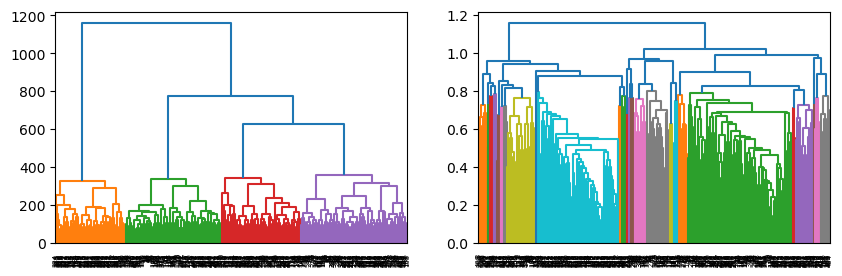

In [83]:
from scipy.cluster.hierarchy import dendrogram, linkage
fig, ax = plt.subplots(1,2, figsize=(10,3))
linkage_data = linkage(bundle_opt, method='ward', metric='euclidean')
linkage_data_cosine = linkage(bundle_opt, method='average', metric='cosine')
dendrogram(linkage_data, ax=ax[0], color_threshold=450)
dendrogram(linkage_data_cosine, ax=ax[1], color_threshold=0.8)
plt.show()

### Hierarchical Clustering on bundles

#### Hierarchical clustering on optimized bundles' values

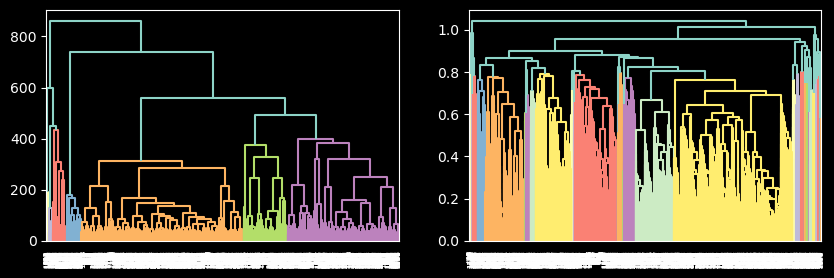

In [103]:
ethresh = 450
cthresh = 0.8
from scipy.cluster.hierarchy import dendrogram, linkage
fig, ax = plt.subplots(1,2, figsize=(10,3))
linkage_data = linkage(bundle_opt.T, method='ward', metric='euclidean')
linkage_data_cosine = linkage(bundle_opt.T, method='average', metric='cosine')
dendrogram(linkage_data, ax=ax[0], color_threshold=ethresh)
dendrogram(linkage_data_cosine, ax=ax[1], color_threshold=cthresh)
plt.show()

#### Euclidean Agglomerative Clustering

In [104]:
cluster_ward = AgglomerativeClustering(
    n_clusters=None, affinity='euclidean', linkage='ward', compute_full_tree=True, distance_threshold=ethresh)

cluster_ward.fit(bundle_opt.T)
labels_ward = cluster_ward.labels_

nb_clusterward = len(np.unique(labels_ward))

/Users/mikichan/miniconda3/envs/microstruct_atlasing/lib/python3.8/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


In [105]:
cluster_opts = []
for k in range(nb_clusterward):
    cluster_opt = np.zeros_like(bundle_opt[0])
    cluster_opt[np.where(labels_ward==k)[0]] = bundle_opt[:, np.where(labels_ward==k)[0]].mean()
    cluster_opts.append(cluster_opt)

cluster_inpainteds = []
for k in range(nb_clusterward):
    _, cluster_inpainted = inpaint_utils.interpolate_activity(fmri_coords, bundles_labels, cluster_opts[k], vdim, 
                                                        wmmask=wm_mask_subj, normalizing=True, verbose=False)
    cluster_inpainteds.append(cluster_inpainted)

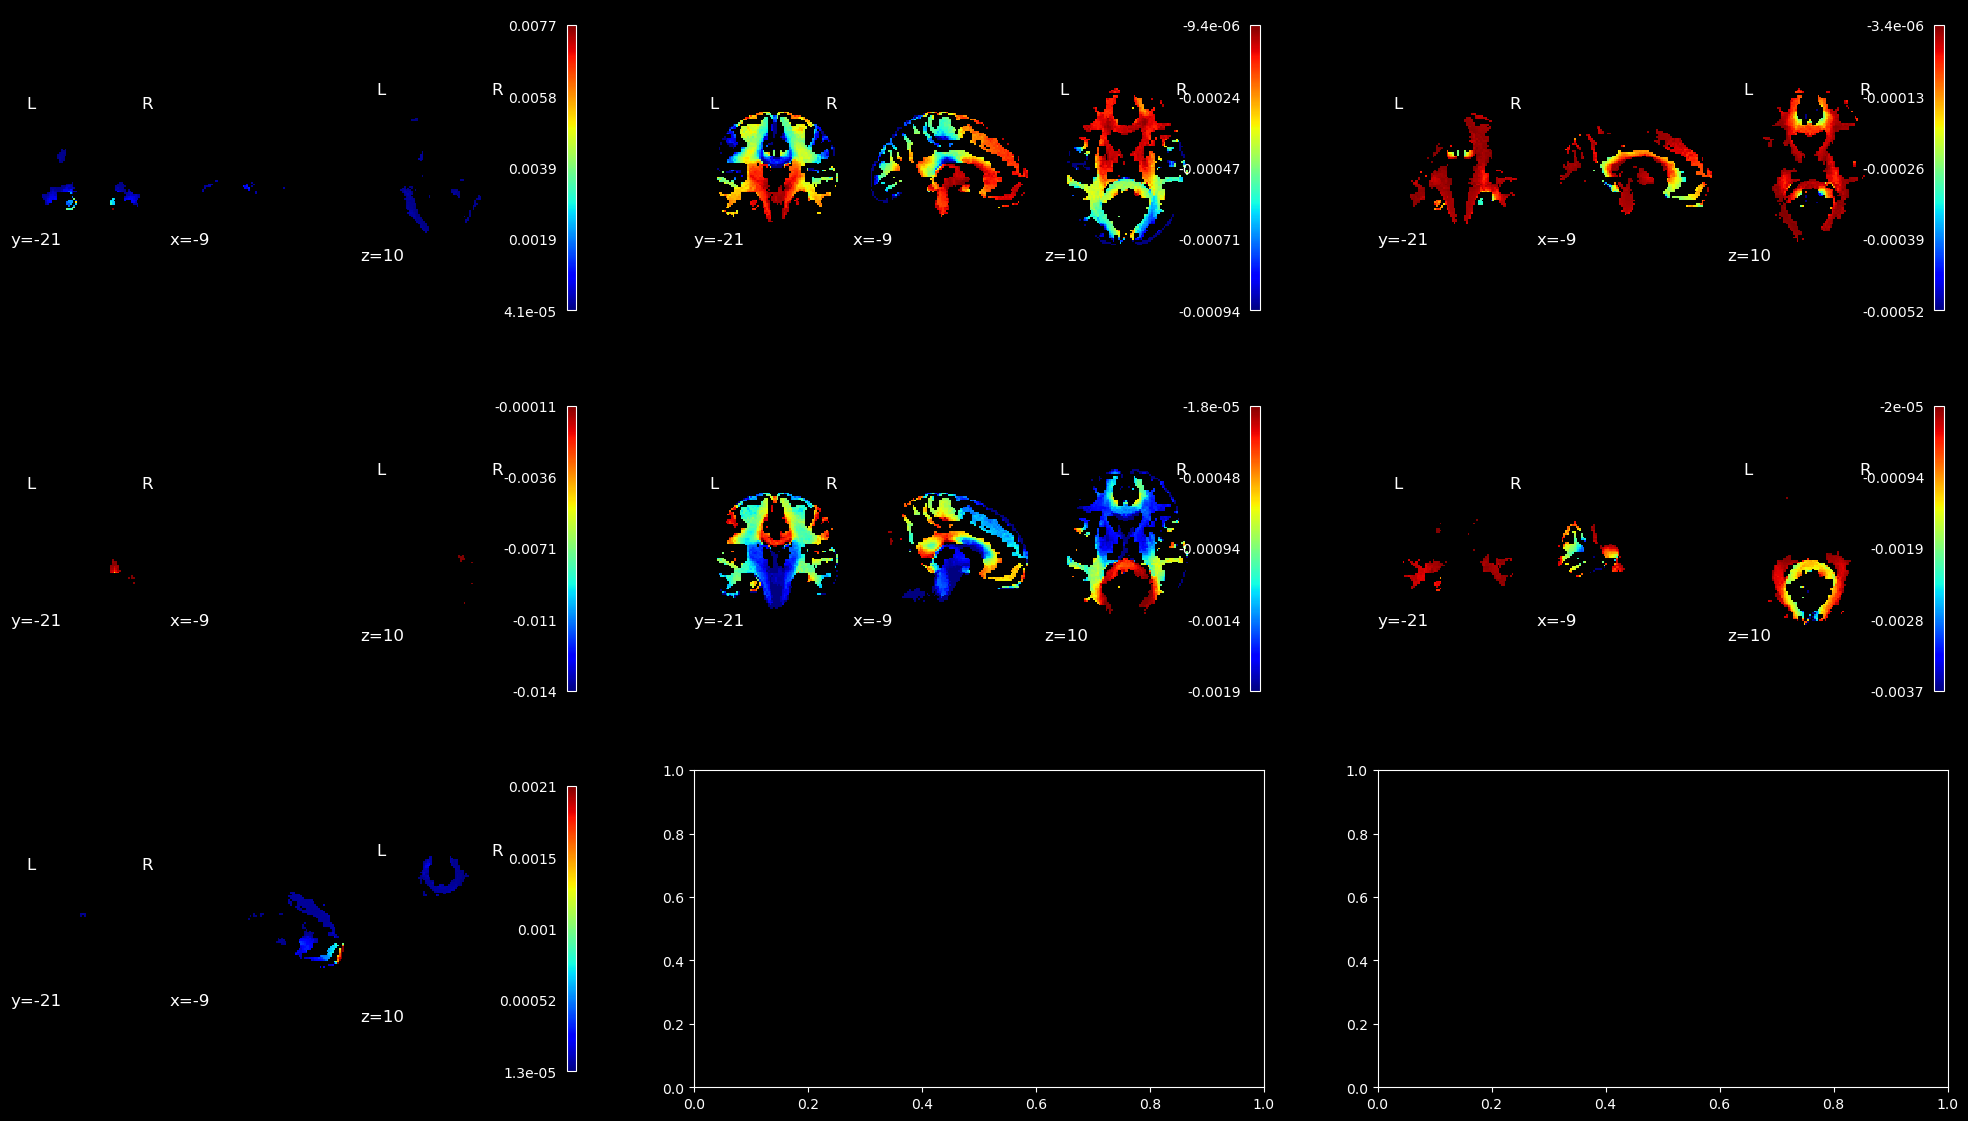

In [106]:
fig, ax = plt.subplots(nb_clusterward//3+1, 3, figsize=(25, nb_clusterward*2))
for k in range(nb_clusterward):
    
    inpaint_mod = deepcopy(cluster_inpainteds[k])
    vmin = np.quantile(inpaint_mod[inpaint_mod!=-100000], 0)
    vmax = np.quantile(inpaint_mod[inpaint_mod!=-100000], 1)
    # inpaint_mod[inpaint_mod!=0] = inpaint_mod[inpaint_mod!=0] - inpaint_mod[inpaint_mod!=0].mean()
    plot_epi(nib.Nifti1Image(inpaint_mod, affine=rest_affine),
                         colorbar=True, cut_coords=(-9,-21,10), axes=ax[k//3,k%3],
                        cmap=cmap, vmin=vmin, vmax=vmax, draw_cross=False)

#### Cosine Agglomerative Clustering

In [79]:
cluster_cosine = AgglomerativeClustering(
    n_clusters=None, affinity='cosine', linkage='average', compute_full_tree=True, distance_threshold=cthresh)

cluster_cosine.fit(bundle_opt.T)
labels_cosine = cluster_cosine.labels_

nb_clustercosine = len(np.unique(labels_cosine))

/Users/mikichan/miniconda3/envs/microstruct_atlasing/lib/python3.8/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


In [80]:
cluster_opts = []
for k in range(nb_clustercosine):
    cluster_opt = np.zeros_like(bundle_opt[0])
    cluster_opt[np.where(labels_cosine==k)[0]] = bundle_opt[:, np.where(labels_cosine==k)[0]].mean()
    cluster_opts.append(cluster_opt)

cluster_inpainteds = []
for k in range(nb_clustercosine):
    _, cluster_inpainted = inpaint_utils.interpolate_activity(fmri_coords, bundles_labels, cluster_opts[k], vdim, 
                                                        wmmask=wm_mask_subj, normalizing=True, verbose=False)
    cluster_inpainteds.append(cluster_inpainted)

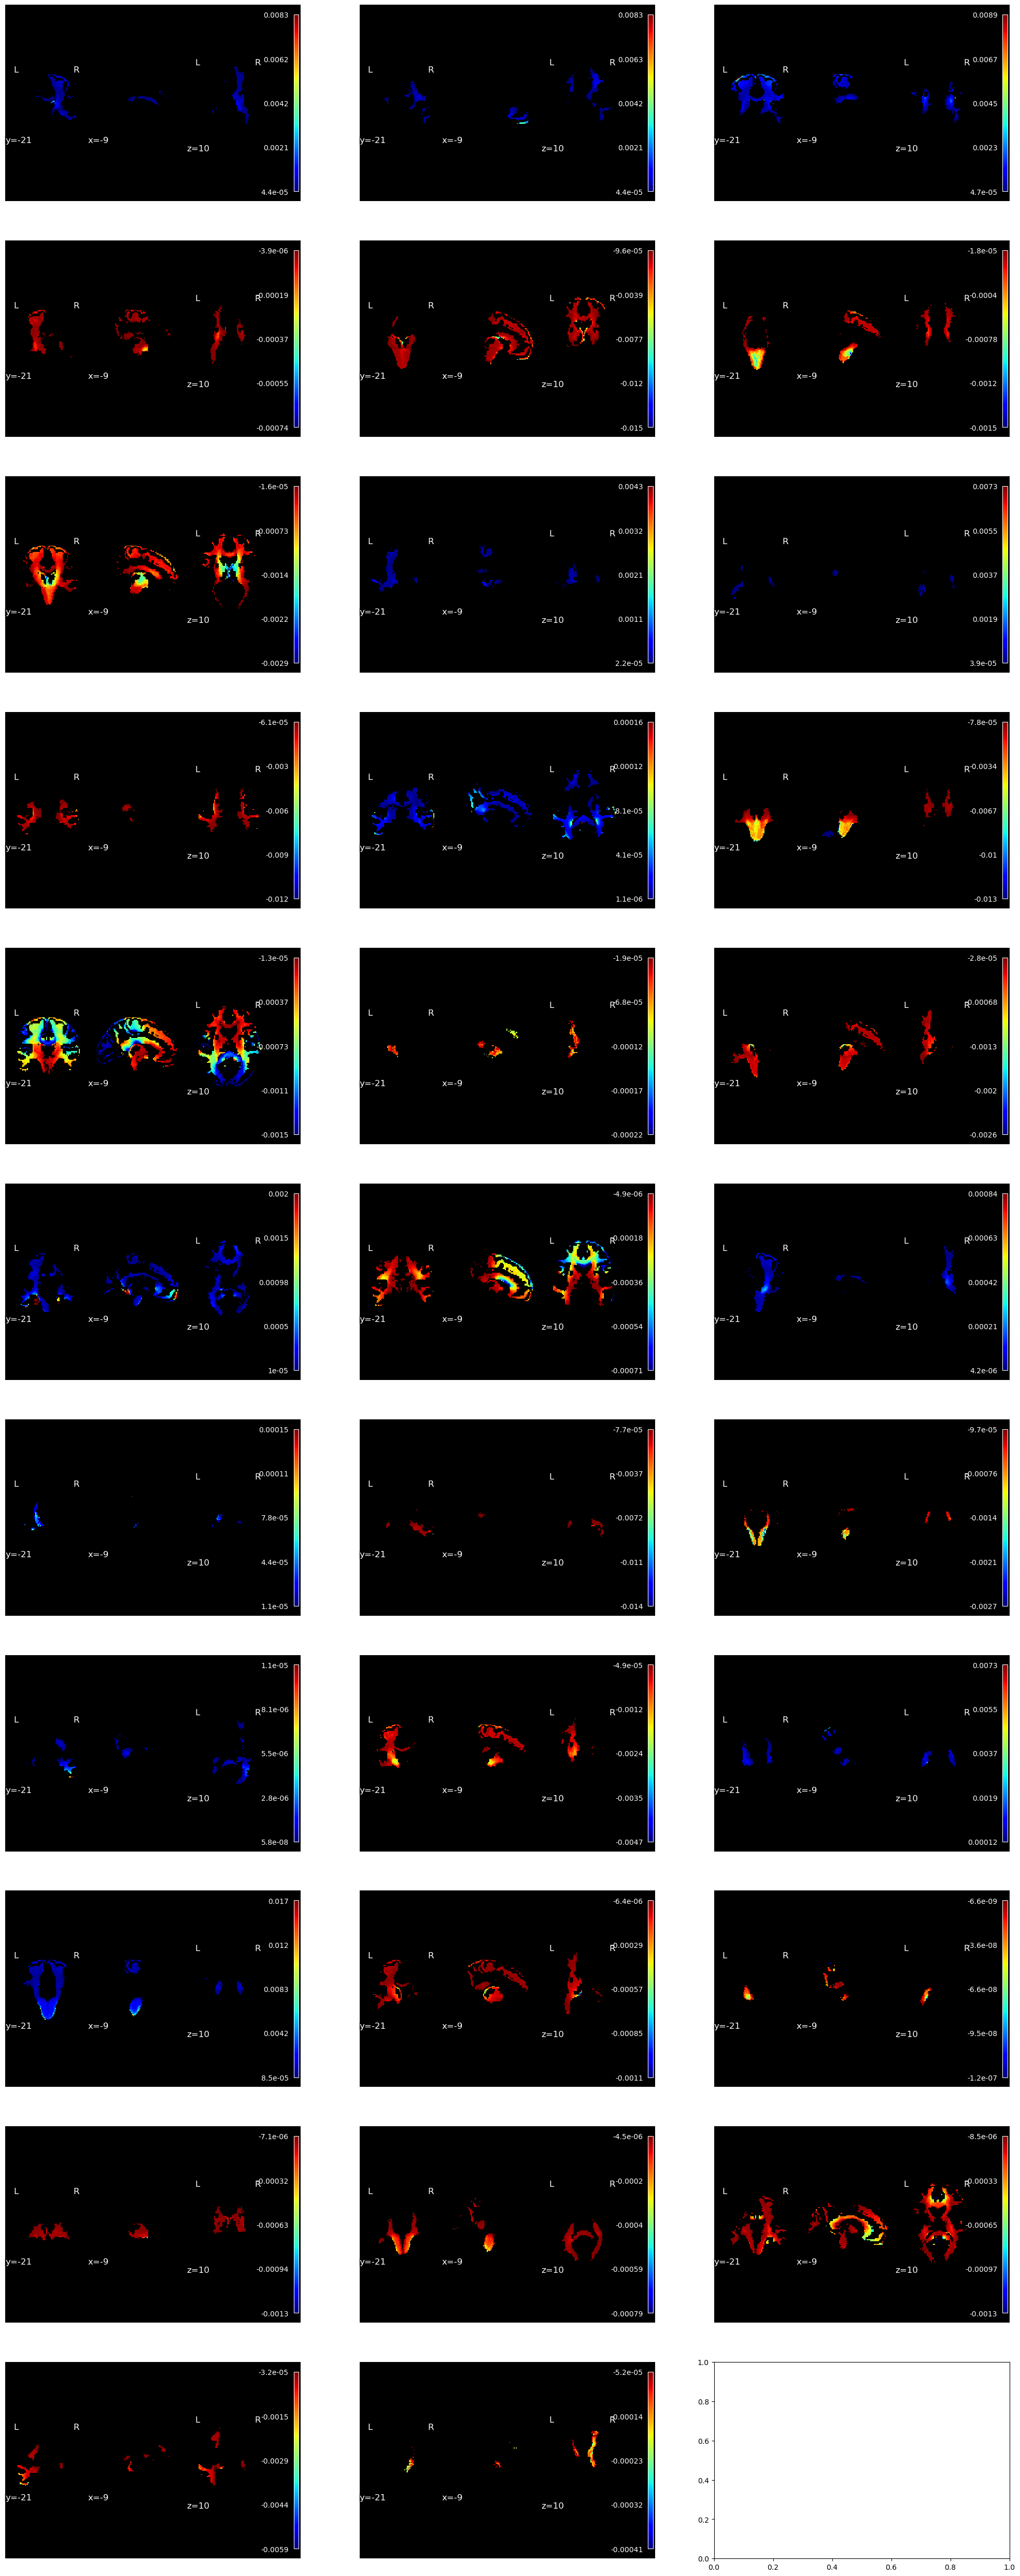

In [81]:
fig, ax = plt.subplots(nb_clustercosine//3+1, 3, figsize=(25, nb_clustercosine*2))
for k in range(nb_clustercosine):
    
    inpaint_mod = deepcopy(cluster_inpainteds[k])
    vmin = np.quantile(inpaint_mod[inpaint_mod!=-100000], 0)
    vmax = np.quantile(inpaint_mod[inpaint_mod!=-100000], 1)
    # inpaint_mod[inpaint_mod!=0] = inpaint_mod[inpaint_mod!=0] - inpaint_mod[inpaint_mod!=0].mean()
    plot_epi(nib.Nifti1Image(inpaint_mod, affine=rest_affine),
                         colorbar=True, cut_coords=(-9,-21,10), axes=ax[k//3,k%3],
                        cmap=cmap, vmin=vmin, vmax=vmax, draw_cross=False)